## Learning the topology of a bayesian networkfrom a database of cases using the K2 algorithm

In [56]:
# Insert data 
x1 <- c(1,1,0,1,0,0,1,0,1,0)
x2 <- c(0,1,0,1,0,1,1,0,1,0)
x3 <- c(0,1,1,1,0,1,1,0,1,0)
data <- cbind(x1,x2,x3)

# Get a serious dataset
library('bnlearn')
data <- as.matrix(alarm)
for (i in seq(37)){
    print(unique(data[,i]))
}

# Get index of each column
#as.matrix(cbind(colnames(data),seq(37)))

best_order_alarm = c(16,37,24,36,22,23,21,13,35,10,31,34,15,12,32,33,14,11,19,4,20,27,18,17,3,25,28,26,29,30,1,2,7,6,9,8,5)
best_order_asia = c(1,3,2,4,6,5,8,7)

[1] "NORMAL" "LOW"    "HIGH"  
[1] "NORMAL" "HIGH"   "LOW"   
[1] "FALSE" "TRUE" 
[1] "LOW"    "NORMAL" "HIGH"  
[1] "NORMAL" "LOW"    "HIGH"  
[1] "HIGH"   "LOW"    "NORMAL"
[1] "HIGH"   "LOW"    "NORMAL"
[1] "HIGH"   "NORMAL" "LOW"   
[1] "HIGH"   "NORMAL" "LOW"   
[1] "NORMAL" "LOW"    "HIGH"  
[1] "NORMAL" "LOW"    "HIGH"  
[1] "LOW"    "NORMAL"
[1] "HIGH"   "NORMAL" "LOW"    "ZERO"  
[1] "ZERO"   "HIGH"   "LOW"    "NORMAL"
[1] "HIGH"   "ZERO"   "NORMAL" "LOW"   
[1] "NORMAL" "LOW"    "HIGH"  
[1] "FALSE" "TRUE" 
[1] "FALSE" "TRUE" 
[1] "FALSE" "TRUE" 
[1] "FALSE" "TRUE" 
[1] "FALSE" "TRUE" 
[1] "NORMAL"     "ESOPHAGEAL" "ONESIDED"  
[1] "FALSE" "TRUE" 
[1] "TRUE"  "FALSE"
[1] "NORMAL" "LOW"    "HIGH"  
[1] "NORMAL" "LOW"    "HIGH"  
[1] "HIGH"   "NORMAL"
[1] "FALSE" "TRUE" 
[1] "HIGH"   "NORMAL" "LOW"   
[1] "FALSE" "TRUE" 
[1] "NORMAL" "HIGH"  
[1] "NORMAL" "LOW"    "HIGH"  
[1] "NORMAL" "LOW"    "HIGH"  
[1] "HIGH"   "ZERO"   "LOW"    "NORMAL"
[1] "LOW"    "ZERO"   "HIGH"   "NOR

## Ordering algorithm

Link with all the algorithms explained:
https://onlinelibrary.wiley.com/doi/full/10.1111/coin.12182 <br>
The use of the mutual information as a criteria for choosing the initial ordering semms to work very well.

### 3.4 Mutual Information 

In [23]:
# install package needed to compute MI
#install.packages('entropy')  <- non serve
#install.packages('infotheo')

library('infotheo')

We assume that x1 is the classification target. As such we place it first on the node ordering.
Then find the rest of it choosing at each turn the node that has max MI with the last element of the ordering.

In [24]:
# define function to compute MI given indexes of the columns
MI_data <- function(x_index, y_index, dataset){
    mutinformation(dataset[,x_index], dataset[,y_index])
}

In [27]:
# initalize order (choose first variable) <- for ALARM we use MVS (16th variable)
order <- c(1)
all_nodes <- seq(ncol(data))

# Compute matrix of mutual information
#MI_matrix <- mapply(MI_data, all_nodes, all_nodes, MoreArgs=(list(data)))
MI_matrix <- matrix(rep(0,length(all_nodes)**2), ncol=length(all_nodes))
for(node in all_nodes){
    MI_matrix[node,] <- sapply(all_nodes, MI_data, y_index=node, dataset=data)
}
MI_sum <- matrix(rowSums(MI_matrix),nrow=1)
print(MI_sum)

# For each turn, add to `order` the node with max MI
while (length(order) != ncol(data)) {
    
    # list all the nodes that haven't been ordered
    node_list <- all_nodes[-order]

    # Compute MI values for these nodes and the last one in `order`
    MI_values <- sapply(node_list, MI_data, y_index=tail(order,1), dataset=data)

    # Find which node has the max MI and add it to `order`
    best_node <- node_list[which.max(MI_values)]
    order <- c(order, best_node)
}

# Print order
cat('The final order is: ')
cat(order)

           [,1]      [,2]       [,3]      [,4]    [,5]      [,6]      [,7]
[1,] 0.05017514 0.8922814 0.09594344 0.6676152 1.02719 0.7344672 0.7496987
         [,8]
[1,] 1.028645
The final order is: 1 3 6 4 7 2 5 8

In [28]:
# double check to verify the correct value of MI
H1 = entropy(data[,1])
H2 = entropy(data[,2])
H12 = entropy(data[,c(1,2)])
MI <- H1 + H2 - H12
MI

[1] 0.0002304651

## K2 Implementation
K2 algorithm can be used to learn the topology of a Bayes network, i.e.  of finding the mostprobable belief-network structure, given a database.
For each node, it chooses its parents between the nodes before it in the `order` sequence (first node will have no parents).

K2 Algorithm: http://web.cs.wpi.edu/~cs539/s11/Projects/k2_algorithm.pdf
In this paper, Ruiz explains the functioning of the K2 algorithm. In particular we report here the Equation 20:

$$ f(i,\pi_i) = \prod_{j=1}^{q_i} \frac{(r_i-1)!}{(N_{ij}+r_i-1)!} \prod_{k=1}^{r_i} \alpha_{ijk}! $$

Since most datasets contain lots of samples and computing a single term of the Equation imply doing a factorial of the number of rows ($N_{ij}$ in the first case where we have no parent, recalling that $N_{ij}=\sum_{k=1}^{r_i}\alpha_{ijk}$), we will compute the logarithm of the function above:

$$ ln(f(i,\pi_i)) = \sum_{j=1}^{q_i} ln\left( \frac{(r_i-1)!}{(N_{ij}+r_i-1)!} \prod_{k=1}^{r_i} \alpha_{ijk}! \right)$$

For each node $i$ and for each configuration of its parents $j\in\{1,q_i\}$, we are going to write the frequency that a node assumes a state $k\in\{1,r_i\}$ using $\alpha_{ijk} \rightarrow \alpha_k$ for simplicity. Each term of the sum described above can be decomposed in the following way:

\begin{align*}
    ln\left( \frac{(r_i-1)!}{(N_{ij}+r_i-1)!} \prod_{k=1}^{r_i} \alpha_{k}! \right)
    \\ = ln((r_i-1)!) + ln\left(\prod_{k=1}^{r_i}\alpha_k!\right) - ln\left(\left(N_{ij}+r_i-1\right)!\right)
    \\ = ln((r_i-1)!) + \sum_{k=1}^{r_i}ln(\alpha_k!) - \sum_{x=1}^{N_{ij}+r_i-1} ln(x)
    \\ = ln((r_i-1)!) + \sum_{n=1}^{max_k(\alpha_k)} C_n ln(n) - \sum_{x=1}^{N_{ij}+r_i-1} ln(x)
    \\ = ln((r_i-1)!) + \sum_{n=1}^{max_k(\alpha_k)} (C_n-1) ln(n) - \sum_{n=max_k(\alpha_k)+1}^{N_{ij}+r_i-1} ln(n)
    \\ = ln((r_i-1)!) + \sum_{n=1}^{N_{ij}+r_i-1} (C_n-1) ln(n)
    ~~~~~~ if ~ C_n=0 ~ \forall n>max_k(\alpha_k)
\end{align*}

Where we introduced $C_n$ as an 'inverse cumulative distribution', representing the number of how many $\alpha_k$ are greater than $n$.

In [38]:
# I have to use a wrapper to use 'sapply' over all possible parents 
# keeping for each one of those the parents that I already have
f_K2_wrapper <- function(new_parent, parents, i){
    f_K2(i, c(parents, new_parent))
}

################################################################


# Function to count how many possible parents' configs there are
num_of_parents_configs <- function(parents_states){
    configs <- 1
    for (p_states in parents_states){
        configs <- configs * length(p_states)
    }
    return(configs)
}


################################################################


# Function to compute the single terms that compose the productory of Equation 20
single_f_term_orig <- function(j, a_ijk, N_ij, r_i){
    factorial(r_i-1) / factorial(N_ij[j]+r_i-1) * prod(factorial(a_ijk[j,]))
}

# ---------------------------------------------------------------

# Function used only in 'single_f_term_new' to count how many alphas are greater than a generic value
num_of_greater_than_x <- function(x, a_ik){
    greater_a_ik <- ifelse(a_ik >= x, 1, 0)
    return(sum(greater_a_ik))
}


# Function to compute the single terms that compose the productory of Equation 20
# (since most dataset will be too big to calculate the factorial over the samples,
#  the formula has been rewritten as above)
single_f_term_log <- function(j, a_ijk, N_ij, r_i){
    
    # To implement the formula written above, we create an 'inverse cumulative distr' of 
    # alpha_ijk[j] to check how many of these values are greater than an x
    x <- seq(N_ij[j]+r_i-1)
    inv_cumulative <- sapply(x, num_of_greater_than_x, a_ik=a_ijk[j,])
    
    # Compute logarithm of the term 
    log_single_f_term <- log(factorial(r_i-1)) + sum((inv_cumulative-1)*log(x))
    return(log_single_f_term)
}


################################################################


# Function used to 'encode' samples: returns the indexes j and k of matrix alpha_ijk that correspond to the event
from_sample_to_jk_index <- function(row_index, node, node_states, parents, parents_states){
    
    #index k is given by the position of the value of the node in 'node_states'
    k <- which(node_states == data[row_index,node])

    # Vector of configs with length q_i is given by encoding all possible
    # configurations a way such that the position of a config is given by:
    #     j = pos_value_p1 + pos_value_p2*(p1_states) + pos_value_p3*(p1_states*p2_states) + ...

    # initializations for computing j
    j <- 0
    iter_p_states_prod <- 1

    # For each parent of the node ...
    for (p_index in seq(length(parents))){

        p <- parents[p_index]
        # ...find the position of its value inside its 'parent_states[p]' and add it to j
        j <- j + iter_p_states_prod * which( unlist(parents_states[p_index]) == data[row_index,p] )

        # update productory of number of states of parents already analyzed
        iter_p_states_prod <- iter_p_states_prod * length(parents_states[p_index])
    }
    
    # return indexes j and k
    c(j,k)
}

In [39]:
library(plyr)

# Returns the result of Equation 20 of the paper in the link
f_K2 <- function(node, parents=vector()){
    
    # Get every possible state of the node
    node_states <- unique(data[,node])
    r_i <- length(node_states)
    
    # For the FIRST ITERATION, the node will have no parents
    if (length(parents)==0){
        
        # check how many times a state of the node appears in the dataset
        alpha_ik_ <- matrix(table(data[,node]), nrow=1)
        
        # Compute N_ij when there are no parents
        N_i_ <- rowSums(alpha_ik_)
        
        # Compute value of the function
        #f <- factorial(r_i-1) / factorial(N_i_+r_i-1) * prod(factorial(alpha_ik_))
        f <- single_f_term_log(1, alpha_ik_, N_i_, r_i) 
        return(f)
    }
    
    # SUCCESSIVE ITERATIONS, where there are parents
    
    # useful info for DEBUGGING
    cat(paste('Node i =', node,'with parents: '))
    cat(parents)
    cat('\n')
    
    # Get every state of each of the parents
    parents_states <- sapply(parents, function(j) unique(data[,j]))
                             
    # If we want to evaluate also nodes with different number of states, we
    # have to change 'parents_states' from a double matrix to a list of arrays
    if (typeof(parents_states) != "list"){
        if (length(parents_states) > 1){
            parents_states <- unname(split(parents_states,(seq_along(parents_states)-1) %/% length(parents_states[,1])))
        }else{
            parents_states <- as.list(parents_states)
        }
    }
                 
    # Number of possible parents configrations
    q_i <- num_of_parents_configs(parents_states)
                             
    # Initialize matrix used to count how many time a config appears in data ('q_i rows' x 'r_i columns')
    alpha_ijk <- matrix(rep(0, q_i*r_i), nrow=q_i)

    # Every sample can be represented by an element of a_ijk, 
    # so we want to compute j and k for every sample in the data
    row_indexes <- seq(length(data[,1]))
    jk_indexes <- sapply(row_indexes, from_sample_to_jk_index, 
                         node, node_states, parents, parents_states)
                        
    jk_indexes <- t(jk_indexes)       
    jk_indexes <- count(jk_indexes)
                             
    # Compute the matrix alpha_ijk that represents our samples
                             
    for (i in seq(nrow(jk_indexes))){
        alpha_ijk[jk_indexes[i,1], jk_indexes[i,2]] <- jk_indexes[i,3]
    }
    #print(alpha_ijk)
                             
    # Now that we have alpha_jk, we can compute N_ij
    N_ij <- rowSums(alpha_ijk)
    
    # Compute every term that compose the productory of Equation 20
    f_terms <- sapply(seq(q_i), single_f_term_log, alpha_ijk, N_ij, r_i)

    # Compute the final value of the productory
    #f <- prod(f_terms)  # if output is of single_f_term_log is exp(log(f))
    f <- sum(f_terms)   # if output is of single_f_term_log is log(f)
    return(f)
}

In [42]:
#  -----------------------------
#  ---------- 'MAIN' -----------
#  -----------------------------
# K2 Algorithm to find parents for each node

# Use a 'dictionary-like' variable to manage parents
library('hash')
structure <- hash()

# First node will have no parents
structure[[as.character(order[1])]] <- vector()
# Set max number of parents for a node 
u <- 10

# Search parents for every node, excluding the first in `order`
for (i in order[-1]) {

    # initilization
    possible_parents <- order[1:length(structure)]
    parents <- vector()
    #P_old <- 0  # should be 'f_K2(i,0)'
    P_old <- f_K2(i)   # should be 'f_K2(i,0)'
    OK.to.proceed <- TRUE
    
    # Find parents for node i
    while (OK.to.proceed && length(parents)<u && length(possible_parents)>0){
        
        # between the possible parents, z is the that maximize f_K2
        every_P_new <- sapply(possible_parents, f_K2_wrapper, parents=parents, i=i)
        P_new <- max(every_P_new)
        z <- possible_parents[which.max(every_P_new)]
        
        # Useful output
        cat(paste('log(P_old) =', P_old,'\n'))
        cat('log(Every_P_new) = ')
        cat(every_P_new)

        # Check if z should become a parent of i (if true, also remove it from possible_parents)
        if (P_new > P_old){
            P_old <- P_new
            parents <- c(parents, z)
            possible_parents <- possible_parents[-which.max(every_P_new)]
            cat(paste('\nChoosed node',z,'as the new parent \n\n'))
        }else{   # if not stop cycle
            OK.to.proceed <- FALSE
            cat(paste('\nStop searching parents for this node \n\n\n'))
        }
    }
    
    # Add the parents of i to the structure
    structure[[as.character(i)]] <- parents
}

cat('\nThe structure below contains the parents of each node:')
structure

Node i = 3 with parents: 1
log(P_old) = -257.766871365406 
log(Every_P_new) = -258.4501
Stop searching parents for this node 


Node i = 6 with parents: 1
Node i = 6 with parents: 3
log(P_old) = -1324.00452111383 
log(Every_P_new) = -1324.836 -1210.766
Choosed node 3 as the new parent 

Node i = 6 with parents: 3 1
log(P_old) = -1210.76643526114 
log(Every_P_new) = -1252.939
Stop searching parents for this node 


Node i = 4 with parents: 1
Node i = 4 with parents: 3
Node i = 4 with parents: 6
log(P_old) = -1220.56815754172 
log(Every_P_new) = -1222.483 -1222.585 -138.3888
Choosed node 6 as the new parent 

Node i = 4 with parents: 6 1
Node i = 4 with parents: 6 3
log(P_old) = -138.388804444101 
log(Every_P_new) = -207.6672 -29.85573
Choosed node 3 as the new parent 

Node i = 4 with parents: 6 3 1
log(P_old) = -29.8557283713999 
log(Every_P_new) = -152.8031
Stop searching parents for this node 


Node i = 7 with parents: 1
Node i = 7 with parents: 3
Node i = 7 with parents: 6
Node i =

<hash> containing 8 key-value pair(s).
  1 : 
  2 : 4
  3 : 
  4 : 6 3
  5 : 2
  6 : 3
  7 : 6
  8 : 5

In [9]:
library(bnstruct)

Loading required package: bitops
Loading required package: Matrix
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:bnlearn’:

    compare, degree, path, subgraph

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘bnstruct’

The following objects are masked from ‘package:bnlearn’:

    impute, read.bif, read.dsc, read.net, shd, write.dsc



In [10]:
colsize <- sapply(seq(ncol(data)), function(i) length(unique(data[,i])))
                  
BNdata <- BNDataset(data = data.matrix(data.frame(data)),
                    discreteness = rep(T,ncol(data)),
                    variables = colnames(data),
                    node.sizes = colsize)

In [11]:
net <- BN(BNdata)

In [12]:
#net <- learn.network(BNdata)
adj_matrix <- dag(net)
for (j in 1:length(as.list(structure))){
    #cat(j)
    adj_matrix[structure[[toString(j)]], j] <- 1
    }

dag(net) <- adj_matrix

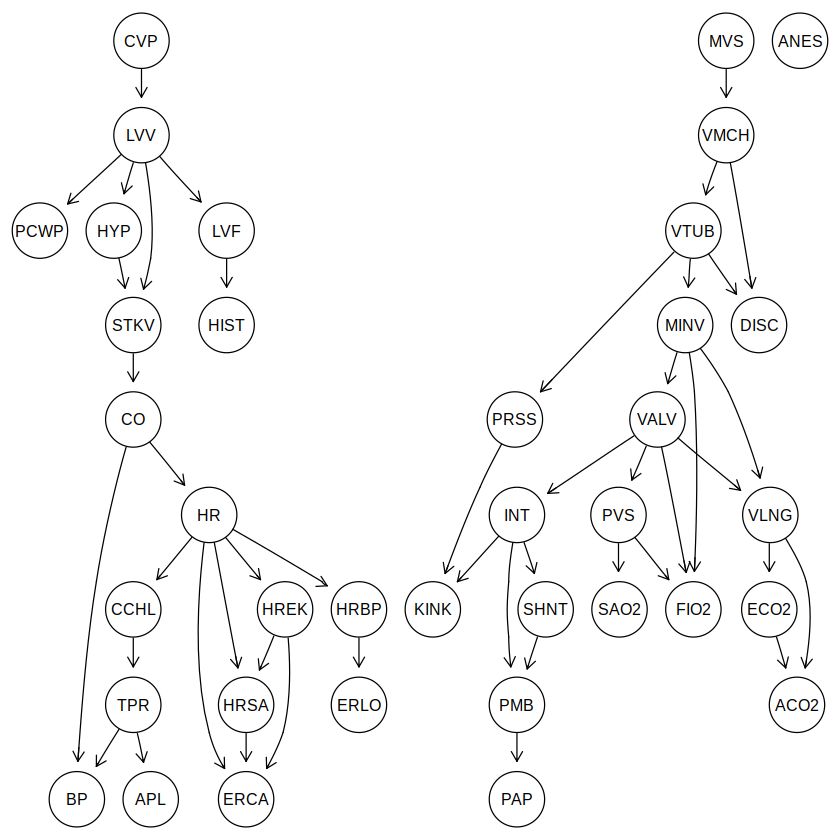

In [18]:
library(Rgraphviz)

e = empty.graph(variables(net))
amat(e) = dag(net)
graphviz.plot(e)

In [14]:
net <- learn.params(net, BNdata)
engine <- InferenceEngine(net)

#results <- em(engine, BNdata)

bnstruct :: learning network parameters ... 


node  1 
node  2 
node  3 
node  4 
node  5 
node  6 
node  7 
node  8 
node  9 
node  10 
node  11 
node  12 
node  13 
node  14 
node  15 
node  16 
node  17 
node  18 
node  19 
node  20 
node  21 
node  22 
node  23 
node  24 
node  25 
node  26 
node  27 
node  28 
node  29 
node  30 
node  31 
node  32 
node  33 
node  34 
node  35 
node  36 
node  37 


bnstruct :: parameter learning done.


In [15]:
#results <- em(engine, BNdata)
obs <- list("observed.vars" = c(1),
            "observed.vals" = c(1))

engine <- InferenceEngine(net)
engine <- belief.propagation(engine, obs)
new.net <- updated.bn(engine)
names(cpts(new.net)) <- variables(net)

cpts(new.net)


$CVP
CVP
1 2 3 
1 0 0 

$PCWP
      LVV
PCWP             1          2           3
  [1,] 0.949246283 0.01139225 0.009133951
  [2,] 0.009749447 0.95399043 0.039673605
  [3,] 0.041004270 0.03461732 0.951192444

$HIST
      LVF
HIST            1         2
  [1,] 0.98909813 0.1072691
  [2,] 0.01090187 0.8927309

$TPR
      CCHL
TPR            1          2
  [1,] 0.1006291 0.91192259
  [2,] 0.3993764 0.01931822
  [3,] 0.4999945 0.06875919

$BP
, , CO = 1

      BP
TPR         [,1]       [,2]       [,3]
  [1,] 0.8976898 0.01244387 0.08986636
  [2,] 0.0107964 0.89820292 0.09100069
  [3,] 0.7445415 0.04845009 0.20700839

, , CO = 2

      BP
TPR          [,1]      [,2]        [,3]
  [1,] 0.09248826 0.2878487 0.619663076
  [2,] 0.00801211 0.9889603 0.003027618
  [3,] 0.01721494 0.9741631 0.008621937

, , CO = 3

      BP
TPR           [,1]       [,2]        [,3]
  [1,] 0.542209638 0.04913466 0.408655705
  [2,] 0.006954222 0.98609156 0.006954222
  [3,] 0.051983422 0.10153937 0.846477205


$CO
      STKV
CO              1           2          3
  [1,] 0.88573333 0.007864714 0.65631324
  [2,] 0.01333333 0.849700022 0.03694599
  [3,] 0.10093333 0.142435264 0.30674077

$HRBP
      HR
HRBP             1          2          3
  [1,] 0.930506820 0.01581823 0.02484637
  [2,] 0.009881503 0.39373023 0.94243099
  [3,] 0.059611677 0.59045154 0.03272264

$HREK
      HR
HREK             1         2          3
  [1,] 0.883825795 0.3031349 0.04624926
  [2,] 0.007413144 0.3678458 0.91349428
  [3,] 0.108761061 0.3290193 0.04025645

$HRSA
, , HR = 1

      HRSA
HREK         [,1]         [,2]        [,3]
  [1,] 0.98142993 0.0092028926 0.009367176
  [2,] 0.90134204 0.0003627131 0.098295248
  [3,] 0.09881579 0.0107048382 0.890479369

, , HR = 2

      HRSA
HREK        [,1]      [,2]      [,3]
  [1,] 0.2991777 0.4443390 0.2564832
  [2,] 0.3169143 0.3732082 0.3098775
  [3,] 0.4093823 0.2205711 0.3700466

, , HR = 3

      HRSA
HREK         [,1]      [,2]       [,3]
  [1,] 0.27039627 0.4592075 0.27039627
  [2,] 0.02381151 0.9529393 0.02324919
  [3,] 0.28512917 0.4722747 0.24259609


$PAP
      PMB
PAP             1          2
  [1,] 0.04991875 0.79399838
  [2,] 0.05092908 0.02027575
  [3,] 0.89915216 0.18572587

$SAO2
      PVS
SAO2            1           2          3
  [1,] 0.92054373 0.009870018 0.01381562
  [2,] 0.05032335 0.979198746 0.14041698
  [3,] 0.02913292 0.010931236 0.84576740

$FIO2
, , 1, VALV = 1

      MINV
FIO2          [,1]         [,2]         [,3]        [,4]
  [1,] 0.002490011 0.0001764914 0.0002313744 0.005373961
  [2,] 0.997509989 0.9998235086 0.9997686256 0.994626039

, , 2, VALV = 1

      MINV
FIO2         [,1] [,2] [,3]        [,4]
  [1,] 0.04465525  0.5  0.5 0.005154639
  [2,] 0.95534475  0.5  0.5 0.994845361

, , 3, VALV = 1

      MINV
FIO2        [,1]       [,2] [,3]      [,4]
  [1,] 0.8578555 0.98979592  0.5 0.7495667
  [2,] 0.1421445 0.01020408  0.5 0.2504333

, , 1, VALV = 2

      MINV
FIO2   [,1]      [,2] [,3]        [,4]
  [1,]  0.5 0.1181151  0.5 0.002590674
  [2,]  0.5 0.8818849  0.5 0.997409326

, , 2, VALV = 2

      MINV
FIO2         [,1]       [,2]      [,3]       [,4]
  [1,] 0.03818687 0.05258313 0.1115607 0.05532089
  [2,] 0.96181313 0.94741687 0.8884393 0.94467911

, , 3, VALV = 2

      MINV
FIO2          [,1]       [,2]       [,3]   [,4]
  [1,] 0.002590674 0.07164105 0.01020408 0.0008
  [2,] 0.997409326 0.92835895 0.98979592 0.9992

, , 1, VALV = 3

      MINV
FIO2   [,1]       [,2]        [,3]        [,4]
  [1,]  0.5 0.01020408 0.002590674 0.002590674
  [2,]  0.5 0.98979592 0.997409326 0.997409326

, , 2, VALV = 3

      MINV
FIO2         [,1]       [,2]       [,3]       [,4]
  [1,] 0.04101147 0.01174619 0.04952818 0.05911049
  [2,] 0.95898853 0.98825381 0.95047182 0.94088951

, , 3, VALV = 3

      MINV
FIO2          [,1]        [,2]         [,3]        [,4]
  [1,] 0.002590674 0.001730104 0.0005202914 0.001039501
  [2,] 0.997409326 0.998269896 0.9994797086 0.998960499

, , 1, VALV = 4

      MINV
FIO2   [,1] [,

In [16]:
# sample.row(net) <- single sample
sampled.data <- sample.dataset(net, n=10) # new sampled dataset
raw.data(sampled.data)

Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  11 12 14 21 22 26 30 31 32 33 35 37”Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  11 12 14 21 22 26 30 31 32 33 35 37”Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  11 12 14 21 22 26 30 31 32 33 35 37”Warning message in validityMethod(object):
“ Not all of the possible values have been observed for variables  11 12 14 21 22 26 30 31 32 33 35 37”

CVP,PCWP,HIST,TPR,BP,CO,HRBP,HREK,HRSA,PAP,⋯,ERLO,HR,ERCA,SHNT,PVS,ACO2,VALV,VLNG,VTUB,VMCH
3,3,1,2,2,1,1,1,1,3,⋯,1,1,1,2,2,2,4,4,2,3
3,3,1,3,1,1,1,1,1,3,⋯,1,1,1,2,2,3,4,4,2,3
3,3,1,3,2,2,1,1,1,3,⋯,1,1,1,2,2,2,4,4,2,3
3,1,1,2,2,1,1,1,1,3,⋯,1,1,1,2,2,2,4,4,2,3
3,3,1,1,1,3,3,2,2,3,⋯,2,3,1,2,1,3,1,2,4,2
2,2,2,3,3,1,1,1,1,1,⋯,1,1,1,2,1,2,1,2,4,3
3,3,1,3,3,3,2,3,2,3,⋯,1,3,1,2,2,2,4,4,2,3
3,1,1,1,1,2,2,2,3,3,⋯,1,3,1,2,2,2,4,4,2,3
1,1,1,2,2,2,1,1,1,3,⋯,1,1,1,2,2,2,4,4,2,3
3,3,1,2,3,1,1,1,1,3,⋯,1,1,1,2,1,2,1,2,1,1


In [17]:
ls("package:bnstruct")

[1] "add.observations<-"       "asia"                    
 [3] "belief.propagation"       "bn"                      
 [5] "BN"                       "bn<-"                    
 [7] "BNDataset"                "boot"                    
 [9] "boots"                    "boots<-"                 
[11] "bootstrap"                "build.junction.tree"     
[13] "child"                    "complete"                
[15] "cpts"                     "cpts<-"                  
[17] "dag"                      "dag.to.cpdag"            
[19] "dag<-"                    "data.file"               
[21] "data.file<-"              "discreteness"            
[23] "discreteness<-"           "edge.dir.wpdag"          
[25] "em"                       "get.most.probable.values"
[27] "has.boots"                "has.imputed.boots"       
[29] "has.imputed.data"         "has.raw.data"            
[31] "header.file"              "header.file<-"           
[33] "imp.boots"                "imp.boots<-"             
[35] "impute"                   "imputed.data"            
[37] "imputed.data<-"           "InferenceEngine"         
[39] "jpts"                     "jpts<-"                  
[41] "jt.cliques"               "jt.cliques<-"            
[43] "junction.tree"            "junction.tree<-"         
[45] "knn.impute"               "layering"                
[47] "learn.dynamic.network"    "learn.network"           
[49] "learn.params"             "learn.structure"         
[51] "marginals"                "name"                    
[53] "name<-"                   "node.sizes"              
[55] "node.sizes<-"             "num.boots"               
[57] "num.boots<-"              "num.items"               
[59] "num.items<-"              "num.nodes"               
[61] "num.nodes<-"              "num.time.steps"          
[63] "num.time.steps<-"         "num.variables"           
[65] "num.variables<-"          "observations"            
[67] "observations<-"           "raw.data"                
[69] "raw.data<-"               "read.bif"                
[71] "read.dataset"             "read.dsc"                
[73] "read.net"                 "sample.dataset"          
[75] "sample.row"               "save.to.eps"             
[77] "scoring.func"             "scoring.func<-"          
[79] "shd"                      "show"                    
[81] "struct.algo"              "struct.algo<-"           
[83] "test.updated.bn"          "tune.knn.impute"         
[85] "updated.bn"               "updated.bn<-"            
[87] "variables"                "variables<-"             
[89] "wpdag"                    "wpdag.from.dag"          
[91] "wpdag<-"                  "write_xgmml"             
[93] "write.dsc"